Please read before you use this notebook:

Files that you need to download from the shared folder and upload it to your **My DRIVE**:
- Text Embedding file from shared google drive
- Image Embedding file from shared google drive
- nipseval_500000_v4 metadata file
- patent_figures.zip file
- 50 unique object names


Once you upload the file to your **My Drive** in Google Drive,
- Mount your drive to the google colab. See the Mounting Google Drive section.
- Once the drive is mounted, you should be able to see the **drive** folder in your left navigation pane under **Files**
- Then, unzip the **patent_figures.zip** file (See the Unzipping patent_figures.zip section.).
- After each object annotation, please make sure you reload the vector database (./text.index and ./image.index)
- if the program returns **KeyError** while trying to display the image, re-run the following section: **Reading the new metadata file which appened the figure path from the Google Drive**

**Important Notes**
- Once you start the second session or reopening the colab after first session, or restarting the colab
  - you always have to re-install the packages, mounting the colab with google drive, and run the remaining code cells.
  - In each session when you start, please make sure you run the following section:
    **Checking the number of images. It should be 67,515 segmented images**
  - Google drive sometimes takes time to load all 67K images. This is why you may anticipate **FileNotFound** error. If you see this error or the count is < 67K:
    - re-run the "Unzipping the patent_figures.zip file" section.


Any Question or Concerns, please let Muntabir (mchou001@odu.edu) know asap without any delay.

## Installing packages/libraries

In [ ]:
!pip install faiss-gpu

In [ ]:
!pip install datasets

In [ ]:
!apt install unzip

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unzip is already the newest version (6.0-26ubuntu3.1).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.


## Importing Libraries

In [ ]:
import os
import faiss
from faiss import write_index, read_index
import torch
import re
import requests
import numpy as np
import pandas as pd
from PIL import Image
from io import BytesIO
from datasets import load_dataset
from collections import OrderedDict
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer
import os
import torch
import requests
import numpy as np
import pandas as pd
from PIL import Image
from io import BytesIO
import IPython.display
from datasets import load_dataset
from collections import OrderedDict
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer
from io import StringIO
import glob
import time
import json
import zipfile
from tqdm.notebook import tqdm

## Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Unzipping the patent_figures.zip file

In [ ]:
#!unzip -u "/content/drive/My Drive/VectorSearchEngine/data/patent_figures.zip" -d "/content/drive/My Drive/VectorSearchEngine/data/patent_figures"

## if you prefer to unzip the "patent_figures.zip" directly on google colab. Please note, in each session, you may have to unzip it if you do not see "data" folder in the left navigation pane.
## the below peice of code only takes 2 min to unzip.
!unzip -u "/content/drive/My Drive/VectorSearchEngine/data/patent_figures.zip" -d "./data"

Streaming output truncated to the last 5000 lines.
  inflating: ./data/segmented_50000_v4/USD0831457-20181023-D00012_14.png  
  inflating: ./data/segmented_50000_v4/USD0831457-20181023-D00013_15.png  
  inflating: ./data/segmented_50000_v4/USD0818583-20180522-D00001_1.png  
  inflating: ./data/segmented_50000_v4/USD0818583-20180522-D00002_2.png  
  inflating: ./data/segmented_50000_v4/USD0818583-20180522-D00003_3.png  
  inflating: ./data/segmented_50000_v4/USD0818583-20180522-D00003_4.png  
  inflating: ./data/segmented_50000_v4/USD0818583-20180522-D00004_6.png  
  inflating: ./data/segmented_50000_v4/USD0818583-20180522-D00004_7.png  
  inflating: ./data/segmented_50000_v4/USD0825292-20180814-D00001_1.png  
  inflating: ./data/segmented_50000_v4/USD0825292-20180814-D00002_2.png  
  inflating: ./data/segmented_50000_v4/USD0825292-20180814-D00003_3.png  
  inflating: ./data/segmented_50000_v4/USD0825292-20180814-D00004_4.png  
  inflating: ./data/segmented_50000_v4/USD0825292-20180814-

## Checking the number of images. It should be 67,515 segmented images.

In [172]:
# folder path

## Change the path
dir_path = './data/segmented_50000_v4'
count = 0
# Iterate directory
for path in os.listdir(dir_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(dir_path, path)):
        count += 1
print('File count:', count)

File count: 67515


In [ ]:
# # Opening JSON file and converting it to CSV file
# lst = []
# with open("/content/drive/My Drive/VectorSearchEngine/data/unique_100.json") as f:
#     json_data = json.load(f)
#     lst.append(json_data)
# data = pd.DataFrame(lst).T
# data.columns = ['object_names']
# data.to_csv("unique_obj.csv", index = False)

## Various Utilities (e.g., loading CLIP model, embedding functions, etc.)

In [173]:
# numbers = re.compile(r'(\d+)')
# def numericalSort(value):
#     parts = numbers.split(value)
#     parts[1::2] = map(int, parts[1::2])
#     return parts

########################## Reading all Images Path ##################################
## Replace with your path if you need to create imageonly.csv file
file_path = "./data/segmented_50000_v4/*.png"
def read_img_path(file):
        data = glob.glob(file, recursive=True)
        df = pd.DataFrame(data, columns = ['img_only'])
        return df

################################# CLIP MODEL ###################################

def get_model_info(model_ID, device):
    model = CLIPModel.from_pretrained(model_ID).to(device)
    processor = CLIPProcessor.from_pretrained(model_ID)
    tokenizer = CLIPTokenizer.from_pretrained(model_ID)
    return model, processor, tokenizer

device = "cuda" if torch.cuda.is_available() else "cpu"
model_ID = "openai/clip-vit-base-patch32"
model, processor, tokenizer = get_model_info(model_ID, device)

################################### IMAGE EMBEDDINGS ########################################

def get_single_text_embedding(text):
    inputs = tokenizer(text, return_tensors = "pt").to(device)
    text_embeddings = model.get_text_features(**inputs)
     # convert the embeddings to numpy array
    embedding_as_np = text_embeddings.cpu().detach().numpy()
    return embedding_as_np

################################### TEXT EMBEDDINGS ########################################

def get_single_image_embedding(my_image):
    image = processor(text = None, images = my_image, return_tensors="pt")["pixel_values"].to(device)
    embedding = model.get_image_features(image)
    # convert the embeddings to numpy array
    embedding_as_np = embedding.cpu().detach().numpy()
    return embedding_as_np

## Processing metadata files and added the segmented images (i.e., subfigure_file) path to the metadata file in a new Column

In [174]:
## change the path
metadata = pd.read_csv('/content/drive/My Drive/VectorSearchEngine/data/nipseval_50000_original.csv') ## change this path based on where you saved the metadata file
figure_file = metadata['subfigure_file'] ## this is the column of segemented images
img_path = "./data/segmented_50000_v4/" ## change this path based on where you dowloaded the images

lst1 = []
for i in figure_file:
    f = img_path+i
    lst1.append(f)

dataframe = pd.DataFrame(lst1, columns = ['figure_path'])
dataframe.to_csv('imagepath.csv', index = None)

In [175]:
img_path = pd.read_csv('imagepath.csv')
result = pd.concat([metadata, img_path], axis = 1)
result = result.replace(np.nan, 'none', regex = True)
result.to_csv('patent_67000_segmented_metadata.csv', index = None)

In [176]:
result

,patentID,patentdate,figid,caption,object_infer,aspect,figure_file,subfigure_file,object_title,figure_path
0,USD0884696-20200519,2020-05-19,1,FIG. 1 is a perspective view of a display with...,display with connector and cover,perspective view,USD0884696-20200519-D00001.png,USD0884696-20200519-D00001_1.png,Display with connector and cover,./data/segmented_50000_v4/USD0884696-20200519-...
1,USD0884696-20200519,2020-05-19,2,FIG. 2 is a front view thereof;,display with connector and cover,front view,USD0884696-20200519-D00002.png,USD0884696-20200519-D00002_2.png,Display with connector and cover,./data/segmented_50000_v4/USD0884696-20200519-...
2,USD0884696-20200519,2020-05-19,3,FIG. 3 is a first side view thereof;,display with connector and cover,side view,USD0884696-20200519-D00003.png,USD0884696-20200519-D00003_3.png,Display with connector and cover,./data/segmented_50000_v4/USD0884696-20200519-...
3,USD0884696-20200519,2020-05-19,4,FIG. 4 is a second side view thereof;,display with connector and cover,side view,USD0884696-20200519-D00003.png,USD0884696-20200519-D00003_4.png,Display with connector and cover,./data/segmented_50000_v4/USD0884696-20200519-...
4,USD0884696-20200519,2020-05-19,5,FIG. 5 is a top view thereof;,display with connector and cover,top view,USD0884696-20200519-D00004.png,USD0884696-20200519-D00004_5.png,Display with connector and cover,./data/segmented_50000_v4/USD0884696-20200519-...
...,...,...,...,...,...,...,...,...,...,...
67510,USD0694423-20131126,2013-11-26,1,FIG. 1 is a perspective view of a disposable a...,disposable apparatus for cell separation,perspective view,USD0694423-20131126-D00001.png,USD0694423-20131126-D00001_1.png,Disposable apparatus for cell separation,./data/segmented_50000_v4/USD0694423-20131126-...
67511,USD0694423-20131126,2013-11-26,4,FIG. 4 is a bottom view thereof;,disposable apparatus for cell separation,bottom view,USD0694423-20131126-D00004.png,USD0694423-20131126-D00004_4.png,Disposable apparatus for cell separation,./data/segmented_50000_v4/USD0694423-20131126-...
67512,USD0694423-20131126,2013-11-26,5,FIG. 5 is a right side view thereof;,disposable apparatus for cell separation,right side view,USD0694423-20131126-D00005.png,USD0694423-20131126-D00005_5.png,Disposable apparatus for cell separation,./data/segmented_50000_v4/USD0694423-20131126-...
67513,USD0694423-20131126,2013-11-26,6,"FIG. 6 is a left side view thereof; and,",disposable apparatus for cell separation,left side view,USD0694423-20131126-D00006.png,USD0694423-20131126-D00006_6.png,Disposable apparatus for cell separation,./data/segmented_50000_v4/USD0694423-20131126-...


## Image Embeddings

In [ ]:
# img_embed = []
# for img in tqdm(figure_path, desc = 'Image Embedding is Progress'):
#     images = Image.open(img, 'r')
#     image_embedding = get_single_image_embedding(images)
#     img_embed.append(image_embedding)

In [ ]:
#torch.save(img_embed, 'image_embeddings_v1.pt')

## Text Embeddings

In [ ]:
# text_embed = []
# for txt in tqdm(title, desc = 'Text Embedding is in Progress'):
#     text_embedding = get_single_text_embedding(txt)
#     text_embed.append(text_embedding)

In [ ]:
# torch.save(text_embed, 'text_embeddings_v1.pt')

## Creating Vector Database for Image

In [177]:
###### Load the image embedding ######
embed = torch.load("/content/drive/MyDrive/VectorSearchEngine/data/image_embeddings_v1.pt")
embed_arr = np.array(embed)
embed_slice = embed_arr[:,0,:] ## making the two dimensional array
print(np.shape(embed_slice))

(67515, 512)


In [178]:
img_embedding = embed_slice.shape[1]
img_embedding

512

In [179]:
#index = faiss.IndexFlatL2(img_embedding)
nlist = 5
quantizer = faiss.IndexFlatL2(img_embedding)
img_index = faiss.IndexIVFFlat(quantizer, img_embedding, nlist)

In [180]:
img_index.is_trained

False

In [181]:
img_index.train(embed_slice)
img_index.is_trained

True

In [182]:
img_index.add(embed_slice)
img_index.ntotal

67515

In [183]:
write_index(img_index, "image.index")

## Create a Vector Database for Text

In [184]:
###### Load the text embedding ######

txt_embed = torch.load("/content/drive/MyDrive/VectorSearchEngine/data/text_embeddings_v1.pt") ## Replace with your path
txt_embed_arr = np.array(txt_embed)
txt_embed_slice = txt_embed_arr[:,0,:] ## making the two dimensional array
print(np.shape(txt_embed_slice))

(67515, 512)


In [185]:
txt_embedding = embed_slice.shape[1]
txt_embedding

512

In [186]:
#txt_index = faiss.IndexFlatL2(txt_embedding)
nlist = 5
quantizer = faiss.IndexFlatL2(txt_embedding)
txt_index = faiss.IndexIVFFlat(quantizer, txt_embedding, nlist)

In [187]:
txt_index.is_trained

False

In [188]:
txt_index.train(txt_embed_slice)
txt_index.is_trained

True

In [189]:
txt_index.add(txt_embed_slice)
txt_index.ntotal

67515

In [190]:
write_index(txt_index, "text.index")

## Create a Vector Database with the concatnated version of image and text pairs

In [ ]:
# img_embed = torch.load("./../vector_search/image_embeddings_v1.pt") ## Replace with your path
# txt_embed = torch.load("./../vector_search/text_embeddings_v1.pt") ## Replace with your path

# img_embed_arr = np.array(img_embed)
# img_embed_slice = img_embed_arr[:,0,:]

# txt_embed_arr = np.array(txt_embed)
# txt_embed_slice = txt_embed_arr[:,0,:]


# concat = np.concatenate((img_embed, txt_embed), axis =1)
# concat_arr = np.array(concat)
# concat_slice = concat_arr[:,0,:]

# concatanated = np.ascontiguousarray(concat_slice)

# print(concatanated.flags)
# print(np.shape(concatanated))

In [ ]:
# img_txt_embed = concatanated.shape[1]
# img_txt_embed

In [ ]:
# nlist = 5
# quantizer = faiss.IndexFlatL2(img_txt_embed)
# img_txt_index = faiss.IndexIVFFlat(quantizer, img_txt_embed, nlist)

In [ ]:
# img_txt_index.is_trained

In [ ]:
# img_txt_index.train(concatanated)
# img_txt_index.is_trained

In [ ]:
# img_txt_index.add(concatanated)
# img_txt_index.ntotal

In [ ]:
# write_index(img_txt_index, "large_v1.index")

## Reading the new metadata file which appened the figure path from the Google Drive

In [202]:
data = pd.read_csv('patent_67000_segmented_metadata.csv')
caps = data['object_infer']
viewpoint = data['aspect']
# figure_path = data['figure_path']
# title = data['object_title']
segmented_image = data['subfigure_file']

## Loading Vector Database for Text

In [192]:
idx = read_index("./text.index")

## Embed the Query Text

In [193]:
queryText = "Earmuff"
query_embedding_txt = get_single_text_embedding(queryText)

## Search against the Vector Database

In [194]:
%%time
txtQuery = np.array(query_embedding_txt) ## pass the array of either image or text of the user query
D, I = idx.search(txtQuery, k=35)
print(D)
print('\n')
print(I)

[[4.5137047e-11 4.5137047e-11 4.5137047e-11 4.5137047e-11 4.5137047e-11
  4.5137047e-11 4.5137047e-11 4.5137047e-11 7.8563261e+00 7.8563261e+00
  7.8563261e+00 7.8563261e+00 7.8563261e+00 7.8563261e+00 7.8563261e+00
  7.8563261e+00 7.8563261e+00 7.8563261e+00 7.8563261e+00 2.4402590e+01
  2.4402590e+01 2.4402590e+01 2.4402590e+01 2.4402590e+01 2.5943548e+01
  2.5943548e+01 2.5943548e+01 2.5943548e+01 2.5943548e+01 2.5943548e+01
  2.5943548e+01 2.5943548e+01 2.5943548e+01 2.7233057e+01 2.7233057e+01]]


[[42733 42736 42735 42732 42731 42737 42730 42734 56431 56438 56428 56437
  56434 56433 56430 56435 56436 56432 56429 48377 48378 48376 48379 48380
  50952 50953 50951 50949 50954 50950 50948 50955 50947  5460  5461]]
CPU times: user 15.6 ms, sys: 0 ns, total: 15.6 ms
Wall time: 24.9 ms


## Displaying the search result of Query Text

In [195]:
txt_ann = []
images = []
for x in I:
    for pic in x:
        result = Image.open(data['figure_path'][pic], 'r')
        result = result.resize((200, 300))
        captions = caps[pic] + ", " + viewpoint[pic] + ", " + segmented_image[pic]
        images.extend((result, [captions]))

        ## appending the object names, aspect, and figures in a list
        obj_names = caps[pic]
        aspect = viewpoint[pic]
        img = segmented_image[pic]
        txt_ann.append([obj_names, aspect, img])

In [196]:
data = pd.DataFrame(txt_ann, columns = ['obj_names', 'aspect', 'figure_file'])
## change the csv file name with their object names that you are querying.
## Then download the csv file and open it in your local computer to assign the relevance score (0 -- irrelevant, 0.5 -- somewhat relevant, 1 -- relevant)
data.to_csv("earmuff_txtQuery.csv", index = None)

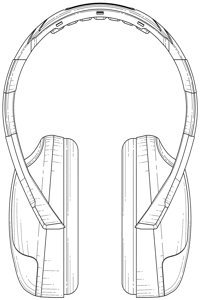

['earmuff, rear view, USD0885683-20200526-D00004_4.png']

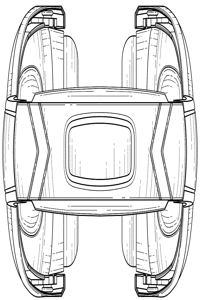

['earmuff, top plan view, USD0885683-20200526-D00007_7.png']

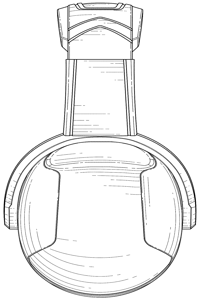

['earmuff, right view, USD0885683-20200526-D00006_6.png']

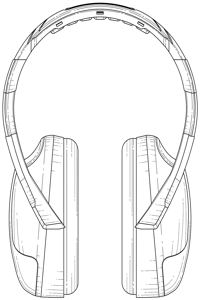

['earmuff, front view, USD0885683-20200526-D00003_3.png']

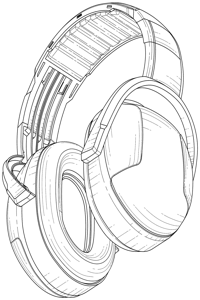

['earmuff, rear bottom perspective view, USD0885683-20200526-D00002_2.png']

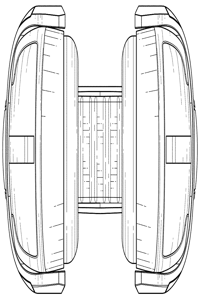

['earmuff, bottom plan view, USD0885683-20200526-D00008_8.png']

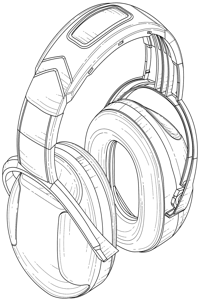

['earmuff, front perspective view, USD0885683-20200526-D00001_1.png']

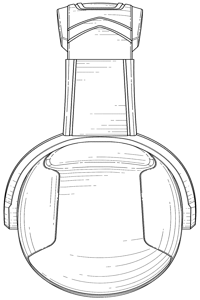

['earmuff, left view, USD0885683-20200526-D00005_5.png']

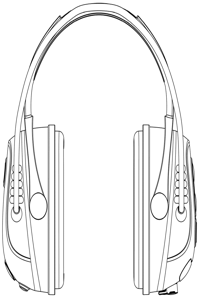

['ear muff headband, rear view, USD0633894-20110308-D00004_4.png']

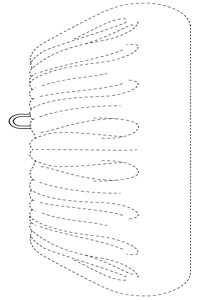

['ear muff, right side elevation view, USD0757367-20160524-D00004_5.png']

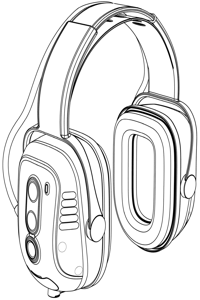

['ear muff headband, upper isometric view, USD0633894-20110308-D00001_1.png']

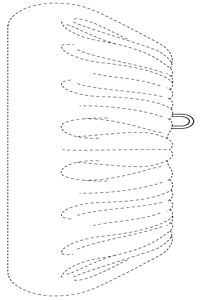

['ear muff, left side elevation view, USD0757367-20160524-D00004_4.png']

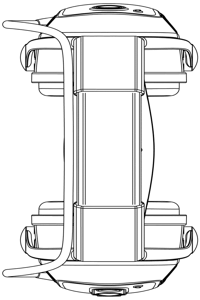

['ear muff headband, top view, USD0633894-20110308-D00007_7.png']

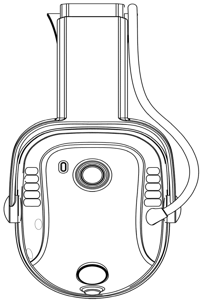

['ear muff headband, left side view, USD0633894-20110308-D00006_6.png']

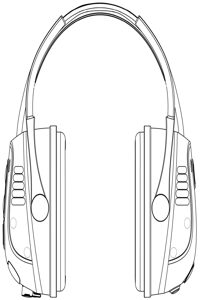

['ear muff headband, front view, USD0633894-20110308-D00003_3.png']

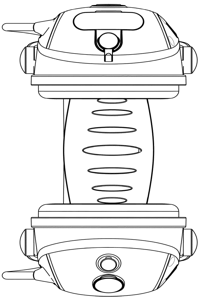

['ear muff headband, bottom view, USD0633894-20110308-D00008_8.png']

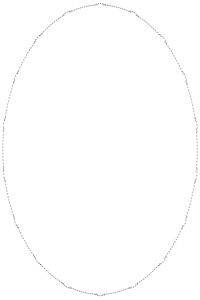

['ear muff, rear view, USD0757367-20160524-D00003_3.png']

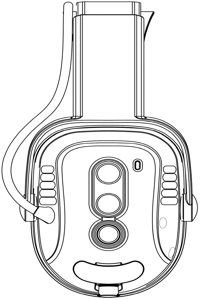

['ear muff headband, right side view, USD0633894-20110308-D00005_5.png']

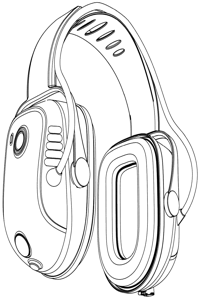

['ear muff headband, lower isometric view, USD0633894-20110308-D00002_2.png']

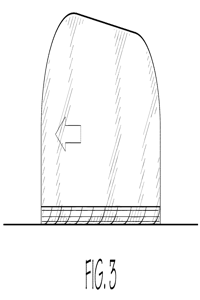

['ear cover, front view, USD0736476-20150811-D00002_4.png']

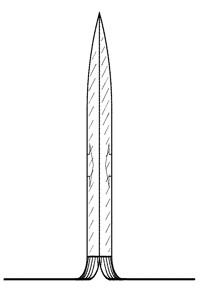

['ear cover, rear view, USD0736476-20150811-D00002_5.png']

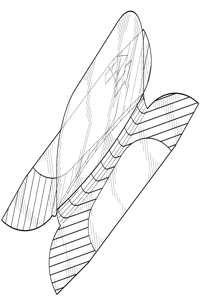

['ear cover, perspective view, USD0736476-20150811-D00001_1.png']

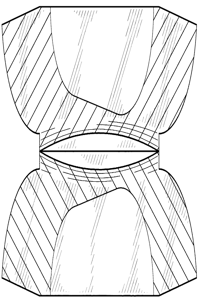

['ear cover, top view, USD0736476-20150811-D00003_6.png']

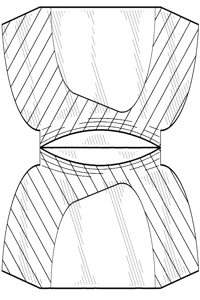

['ear cover, bottom view, USD0736476-20150811-D00003_7.png']

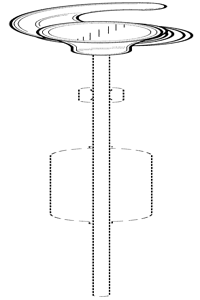

['earbud headset, right side view, USD0899399-20201020-D00006_6.png']

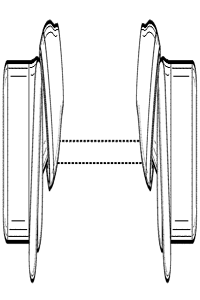

['earbud headset, top view, USD0899399-20201020-D00007_7.png']

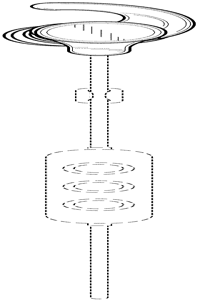

['earbud headset, left side view, USD0899399-20201020-D00005_5.png']

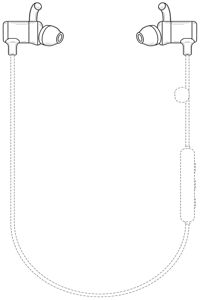

['earbud headset, front view, USD0899399-20201020-D00003_3.png']

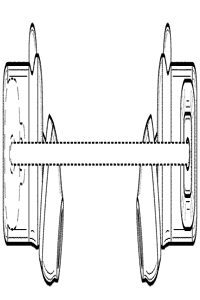

['earbud headset, bottom view, USD0899399-20201020-D00007_8.png']

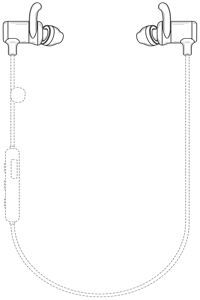

['earbud headset, back view, USD0899399-20201020-D00004_4.png']

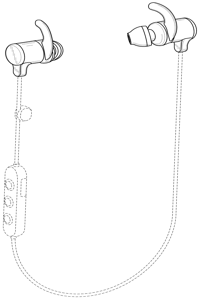

['earbud headset, back left perspective view, USD0899399-20201020-D00002_2.png']

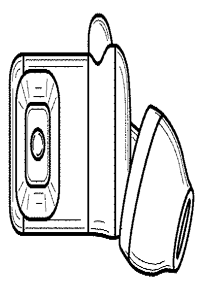

['earbud headset, bottom view, USD0899399-20201020-D00007_9.png']

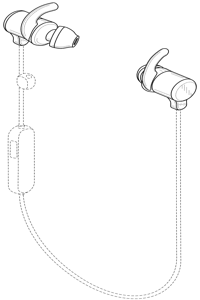

['earbud headset, back right perspective view, USD0899399-20201020-D00001_1.png']

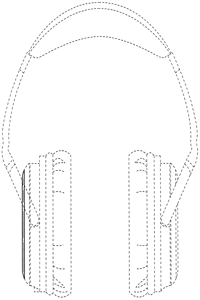

['head set, side elevational view, USD0606970-20091229-D00002_2.png']

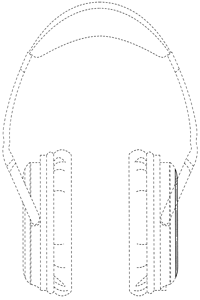

['head set, side elevational view, USD0606970-20091229-D00003_3.png']

In [197]:
for pic in images:
    display(pic)

## Loading vector database for image

In [198]:
idx = read_index("./image.index")

## Embed Query Image

When you are doing image query, you notice that during the text query, we saved the segmented image files in the .csv file. You can directrly choose either the "top view" or "front view" of the image from the .csv file and replace the "figure file" in the path of the "queryImage" below.

In [199]:
queryImage = Image.open("/content/drive/MyDrive/VectorSearchEngine/data/patent_figures/segmented_50000_v4/USD0885683-20200526-D00003_3.png", 'r') ## Replace with your path
query_embedding_img = get_single_image_embedding(queryImage)

## Search against the vector database

In [200]:
%%time
imgQuery = np.array(query_embedding_img) ## pass the array of either image or text of the user query
D, I = idx.search(imgQuery, k=35)
print(D)
print('\n')
print(I)

[[1.19784618e-08 2.22341284e-01 1.22616205e+01 1.34807653e+01
  1.46456261e+01 1.51403751e+01 1.61577454e+01 1.65525398e+01
  1.68586006e+01 1.68921013e+01 1.69024487e+01 1.69397984e+01
  1.69880238e+01 1.73479328e+01 1.74268875e+01 1.79023418e+01
  1.79534588e+01 1.79991283e+01 1.80672741e+01 1.81970310e+01
  1.86440487e+01 1.88923359e+01 1.91469402e+01 1.92625313e+01
  1.93439789e+01 1.94367218e+01 1.94618664e+01 1.96168442e+01
  1.98255196e+01 2.00109062e+01 2.01794071e+01 2.02612343e+01
  2.02880020e+01 2.02932854e+01 2.05211773e+01]]


[[42732 42733 14918 14912 14913 59065 59064  5466 59027  5460  6833 59034
  40461  5467 23609 59576 59058 48918 51731 14919  6839 51737 59023 59026
  59057  5461 42731 40452 48910 61360 24872 59033 63224 59101 15535]]
CPU times: user 14.7 ms, sys: 0 ns, total: 14.7 ms
Wall time: 13.9 ms


## Displaying the search result of Query Image

In [203]:
img_ann = []
images = []
for x in I:
    for pic in x:
        result = Image.open(data['figure_path'][pic], 'r')
        result = result.resize((200, 300))
        captions = caps[pic] + ", " + viewpoint[pic] + ", " + segmented_image[pic]
        images.extend((result, [captions]))

        ## appending the object names, aspect, and figures in a list
        obj_names = caps[pic]
        aspect = viewpoint[pic]
        img = segmented_image[pic]
        img_ann.append([obj_names, aspect, img])

In [204]:
data = pd.DataFrame(img_ann, columns = ['obj_names', 'aspect', 'figure_file'])
## change the csv file name with their object names that you are querying.
## Then download the csv file and open it in your local computer to assign the relevance score (0 -- irrelevant, 0.5 -- somewhat relevant, 1 -- relevant)
data.to_csv("earmuff_imgQuery.csv", index = None)

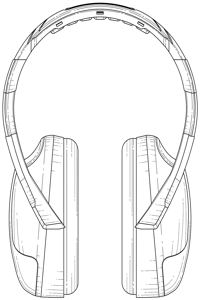

['earmuff, front view, USD0885683-20200526-D00003_3.png']

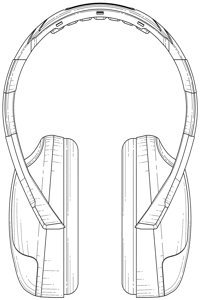

['earmuff, rear view, USD0885683-20200526-D00004_4.png']

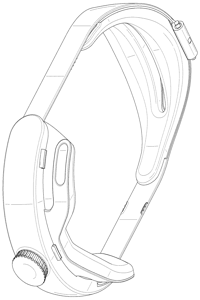

['head mounting frame, perspective views, USD0882569-20200428-D00007_7.png']

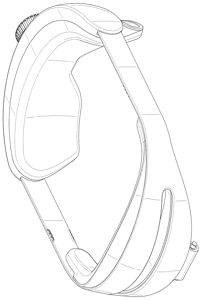

['head mounting frame of head mounted display, perspective view, USD0882569-20200428-D00001_1.png']

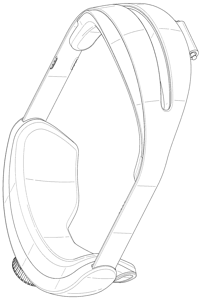

['head mounting frame, perspective views, USD0882569-20200428-D00002_2.png']

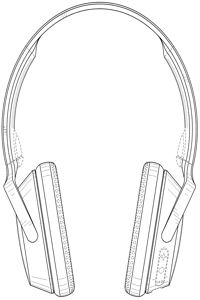

['headphone, back side view, USD0869432-20191210-D00003_3.png']

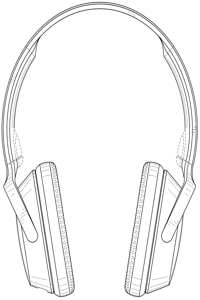

['headphone, front side view, USD0869432-20191210-D00002_2.png']

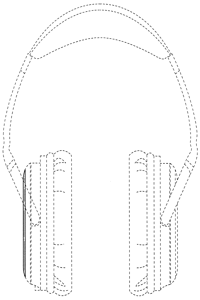

['head set, side elevational view, USD0606969-20091229-D00002_2.png']

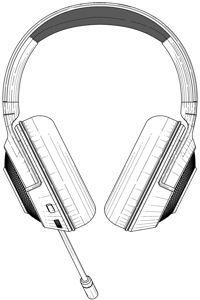

['headphone, color , rear elevational view, USD0896203-20200915-D00010_10.png']

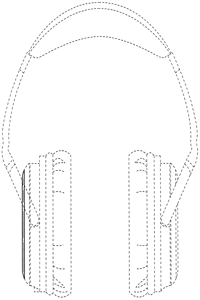

['head set, side elevational view, USD0606970-20091229-D00002_2.png']

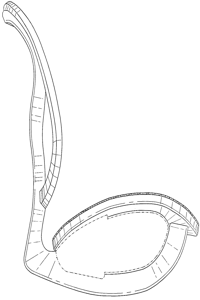

['floor rocker, right side view, USD0677066-20130305-D00009_9.png']

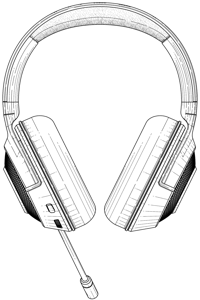

['headphone, rear elevational view, USD0896203-20200915-D00017_17.png']

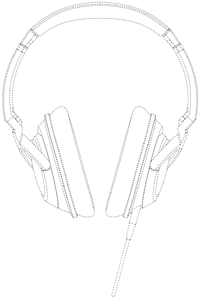

['headphone scrim, front view, USD0727283-20150421-D00008_10.png']

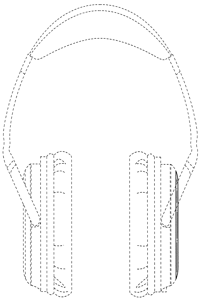

['head set, side elevational view, USD0606969-20091229-D00003_3.png']

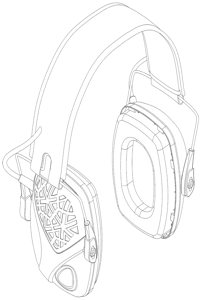

['sports electronics shooting earmuff, perspective view, USD0863690-20191015-D00006_7.png']

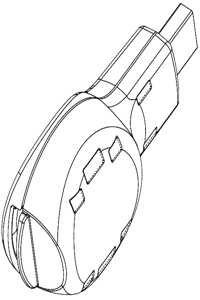

['USB aromatherapy diffuser, bottom rear perspective view, USD0885547-20200526-D00005_11.png']

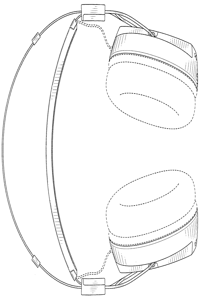

['headphone, rear view, USD0754632-20160426-D00003_3.png']

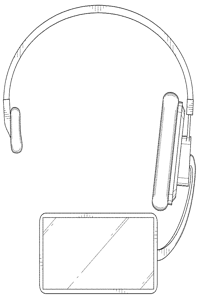

['headset, front view, USD0867363-20191119-D00006_9.png']

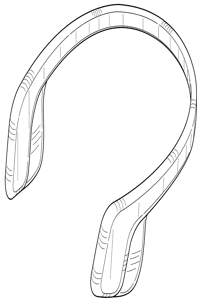

['brain sensing headband, front perspective view, USD0794282-20170815-D00001_1.png']

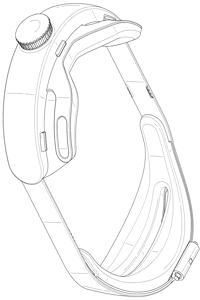

['head mounting frame, perspective views, USD0882569-20200428-D00008_8.png']

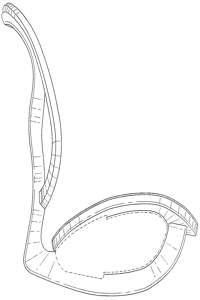

['floor rocker, right side view, USD0677066-20130305-D00015_15.png']

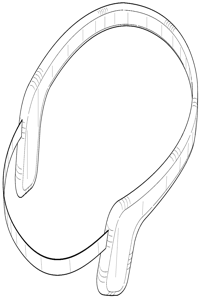

['brain sensing headband, front perspective view, USD0773154-20161206-D00001_1.png']

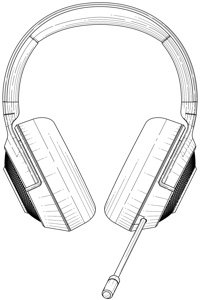

['headphone, front elevational view, USD0896203-20200915-D00002_2.png']

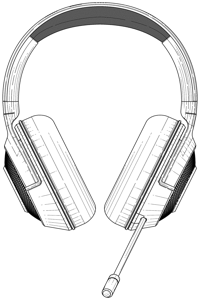

['headphone, color , front elevational view, USD0896203-20200915-D00009_9.png']

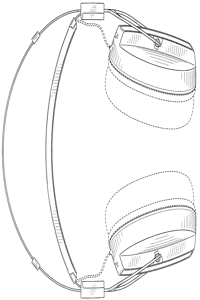

['headphone, front view, USD0754632-20160426-D00002_2.png']

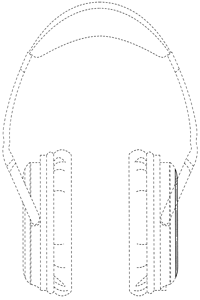

['head set, side elevational view, USD0606970-20091229-D00003_3.png']

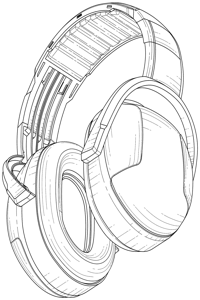

['earmuff, rear bottom perspective view, USD0885683-20200526-D00002_2.png']

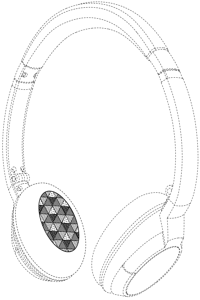

['headphones, perspective view, USD0727283-20150421-D00001_1.png']

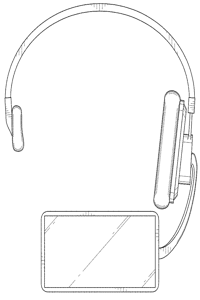

['headset, front view, USD0867363-20191119-D00002_2.png']

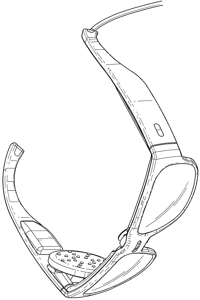

['glasses, top left perspective view, USD0763344-20160809-D00001_1.png']

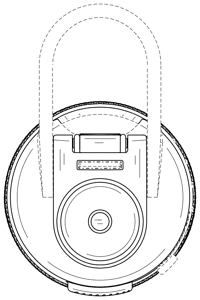

['lid for bottle, top view, USD0894669-20200901-D00004_7.png']

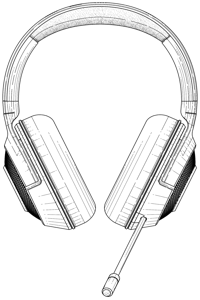

['headphone, front elevational view, USD0896203-20200915-D00016_16.png']

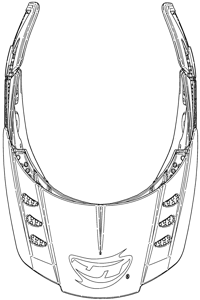

['facemask with side strips, top elevational view, USD0571050-20080610-D00002_2.png']

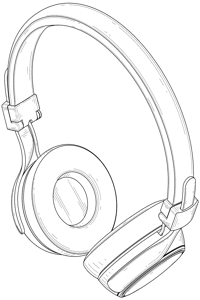

['headphone, perspective view, USD0837764-20190108-D00001_1.png']

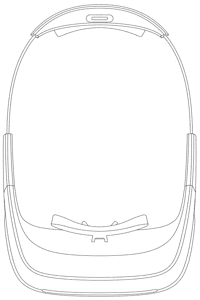

['VR / AR glasses, top view, USD0856329-20190813-D00005_5.png']

In [205]:
for pic in images:
    display(pic)